#Tarea 2: Arquitecturas modernas de Redes Neuronales profundas - CNN & UNETs
----

Estudiante: Rafael Contreras

CI: 30391915

## 1. Introduccion

### Notebooks libro UDL


Anexados notebooks del libro del libro UDL

### Informe sobre preguntas practicas

link al informe

### Explicacion de notebooks

#### [Notebook 10.1 - 1D convolution](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_1_1D_Convolution.ipynb)



#### [Notebook 10.2 - Convolution for MNIST-1D](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_2_Convolution_for_MNIST_1D.ipynb)


#### [Notebook 10.3 - 2D convolution](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_3_2D_Convolution.ipynb)

#### [Notebook 10.4 - Downsampling & upsampling](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_4_Downsampling_and_Upsampling.ipynb)

#### [Notebook 10.5 - Convolution for MNIST](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_5_Convolution_For_MNIST.ipynb)

### 1. Experimento

Realizaremos un modelo de clasificacion de imagenes. Usando imagenes de [MNIST 100](https://www.kaggle.com/code/xinhuamurphywang/number-recognition-from-00-to-99/notebook), donde clasificaremos numeros escritos del 00 al 99. Escogimos este dataset porque es similar al usado en el notebook 10.5, aparte de su simplicidad.

Procederemos a hacer leves modificaciones al modelo original para ver como se comporta. Intentaremos reducir el tamano del modelo y facilitar el computo.

In [123]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np

#### Datos

Al principio pense en descargar la data y cargarla localmente desde el notebook. Luego al ver que kaggle facilitaba la descarga de esta manera, preferi este metodo.

In [124]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("martininf1n1ty/mnist100")  + '/mnist_compressed.npz'
print(path)

/home/rafael/.cache/kagglehub/datasets/martininf1n1ty/mnist100/versions/1/mnist_compressed.npz


Creamos el dataloader, este genera transformaciones que seran necesarias sobre los datos. Entre ellas tenemos el grayscale, el resize y la transformacion a un tensor.

In [125]:
img_size = 128

class MNIST100Dataset(Dataset):
    def __init__(self, npz_file):
        train_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        data = np.load(npz_file)

        self.images = data['train_images']
        self.labels = data['train_labels']
        self.transform = train_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        image = self.transform(image)

        return image, label

Aqui dividimos la data en prueba y validacion. Reducimos el batch size y la cantidad de pruebas por batch debido a que queriamos observar el entrenamiento en mas epochs en los graficos siguientes. Ademas usaremos 1/5 del dataset para acelerar la ejecucion de este notebook.

In [126]:
dataset = MNIST100Dataset(npz_file=path)

dataset_size = len(dataset)
fraction_size = int(0.2 * dataset_size)
unused_size = dataset_size - fraction_size

fraction_dataset, _ = torch.utils.data.random_split(dataset, [fraction_size, unused_size])

# Second split: divide the quarter into train and test (80/20)
train_size = int(0.8 * fraction_size)
test_size = fraction_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(fraction_dataset, [train_size, test_size])

Esta seccion es para observar las imagenes. Podemos ver las 3 primeras del dataset con sus labels respectivos. Los labels van de 0 a 99.

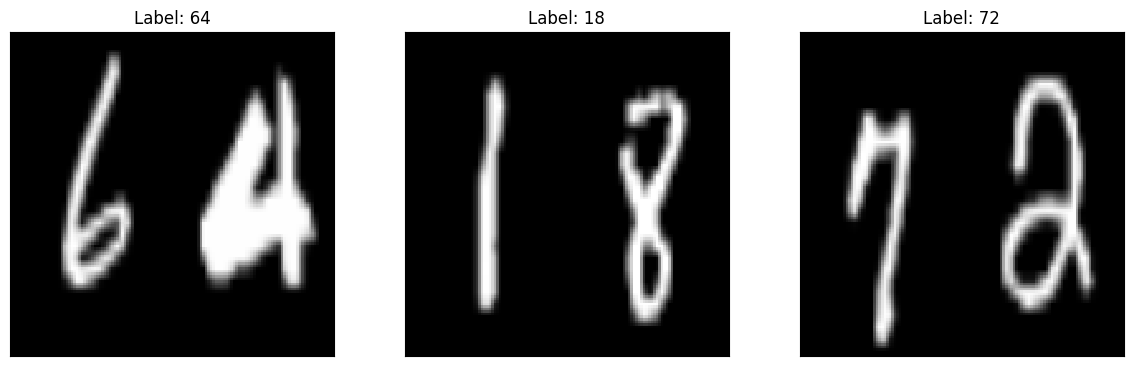

In [127]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.tight_layout()

    image, label = dataset[i]

    if hasattr(image, 'numpy'):
        image = image.numpy()

    # Remove the channel dimension for grayscale display
    image = image.squeeze()

    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Label: {}".format(label))
    plt.xticks([])
    plt.yticks([])

plt.show()

Aqui tenemos la funcion de entrenamiento original modificada ampliamente. Antes esta recibia el epoch id, ahora ella misma ejecuta los epochs dado el argumento num_epochs. Ademas recopila el train history, este es un arreglo por cada epoch donde obtenemos la perdida promedio y la precision.

In [128]:
def train(model, optimizer, num_epochs):
    train_history = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / len(train_loader.dataset)
        epoch_info = {
            'epoch': epoch,
            'avg_loss': avg_loss,
            'accuracy': accuracy,
        }

        train_history.append(epoch_info)
        print(f'Epoch {epoch}: Avg Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')

    return train_history

Aqui definimos la funcion de prueba. Esta usa el dataset de prueba para evaluar la perdida promedio y la precision del modelo resultante. Es bastante similar a la original del notebook con excepcion de que se le pasa como argumento el modelo.

In [129]:
# Run on test data
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Esta funcion nos permite hacer un grafico del historial de entrenamiento. Por ahora esta es la grafica que mas nos interesa. Queremos observar que tan rapido aprenden nuestros modelos (numero de epochs) y comparar esto con el tamaño de los mismos.

In [130]:
def plot_training_history(training_history):
    epochs = [info['epoch'] for info in training_history]
    avg_losses = [info['avg_loss'] for info in training_history]
    accuracies = [info['accuracy'] for info in training_history]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_losses, 'b-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'r-', label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Aqui definiremos una funcion para obtener la cantidad de parametros de cada modelo. Trataremos de obtener la mayor precision posible con la minima cantidad de parametros.

Esta funcion la obtuvimos en esta [respuesta](https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model) de stack overflow

In [131]:
def print_trainable_params(model):
  train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("num of parameters {}".format(train_params))

A continuacion usaremos el modelo original del notebook con ciertas modificaciones para el incremento de clases y el cambio de las imagenes.

Luego iremos iterando sobre este modelo para observar que sucede cuando aumentamos el numero de capas de convolucion. Al agregar max pooling a su vez los modelos se vuelven mas simples debido a la reduccion de parametros (por la reduccion del tamano del input). Respecto a los canales, iremos duplicando la cantidad de canales en cada capa de convolucion.

Mostraremos la cantidad de parametros en cada modelo, la velocidad de entrenamiento respecto a los batches y el accuracy final del modelo entrenado.

#### Model - Original

Este es el modelo original del notebook. Usa dos convoluciones simples, con 10 y 20 canales respectivamentes, max pooling y relu. Tiene un kernel size de 5. Luego aplica las redes lineales estandar para clasificar los 100 elementos posibles.

Primero creamos este modelo con los tamaños de la imagen como argumento y luego creamos el optimizador. Estos seran los argumentos para la funcion de entrenamiento.

In [132]:
class ModelOriginal(nn.Module):
    def __init__(self, img_width,img_height):
        super(ModelOriginal, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(10, 20, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(16820,50),
          nn.ReLU(),
          nn.Linear(50,100),
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = ModelOriginal(img_size,img_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Aqui obtenemos la cantidad de parametros entrenables del modelo. Este tiene 851.430 parametros, esto lo compararemos con las siguientes versiones. Solo hacemos 5 epochs para obtener resultados mas rapidos

In [133]:
print_trainable_params(model)
t_history = train(model,optimizer,5)

num of parameters 851430
Epoch 1: Avg Loss: 2.517096, Accuracy: 38.34%
Epoch 2: Avg Loss: 0.805090, Accuracy: 76.42%
Epoch 3: Avg Loss: 0.537403, Accuracy: 84.30%
Epoch 4: Avg Loss: 0.351578, Accuracy: 89.70%
Epoch 5: Avg Loss: 0.248049, Accuracy: 92.69%


Aqui graficamos la perdida de entrenamiento por epoch y la precision por epoch. Hay que tomar en cuenta que estas metricas son exclusivamente con los datos de entrenamiento.

Observamos que para ambos valores el modelo aproxima rapidamente. Llega al 90% de accuracy en el epoch 5 (seguramente si aumentabamos los epochs este seguiria incrementando). La perdida baja de 1 apenas en el epoch 2. La mayoria de la mejora en el modelo se dio en este epoch.

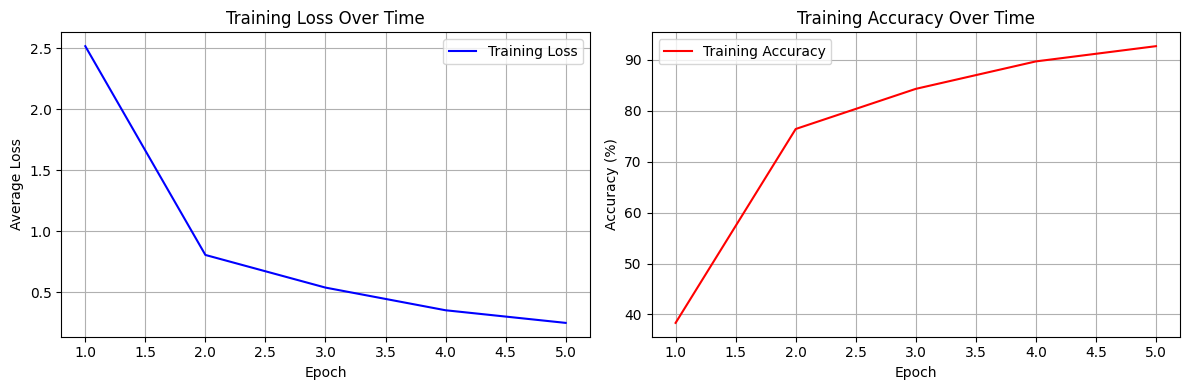

In [134]:
plot_training_history(t_history)

Aqui hacemos una prueba del modelo con datos de validacion. Vemos que el accuracy esta por encima del 90%.

In [135]:
test(model)

/home/rafael/Desktop/ucv/DL/venv/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2469, Accuracy: 11081/12000 (92%)



#### Model - v1

A esta siguiente version le agregamos otra capa de convolucion. El incremento de canales vs la reduccion del ancho y altura de la imagene hace que la cantidad de parametros totales se reduzca. Esto reduce la cantidad de computo requerido para entrenamiento.

In [136]:
class ModelV1(nn.Module):
    def __init__(self, img_width,img_height):
        super(ModelV1, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(10, 20, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(20, 40, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(5760,50),
          nn.ReLU(),
          nn.Linear(50,100),
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = ModelV1(img_size,img_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [137]:
print_trainable_params(model)

num of parameters 318470


Epoch 1: Avg Loss: 3.139043, Accuracy: 27.89%
Epoch 2: Avg Loss: 0.474285, Accuracy: 85.74%
Epoch 3: Avg Loss: 0.268187, Accuracy: 91.76%
Epoch 4: Avg Loss: 0.192244, Accuracy: 94.08%
Epoch 5: Avg Loss: 0.148178, Accuracy: 95.24%

Test set: Avg. loss: 0.2049, Accuracy: 11245/12000 (94%)



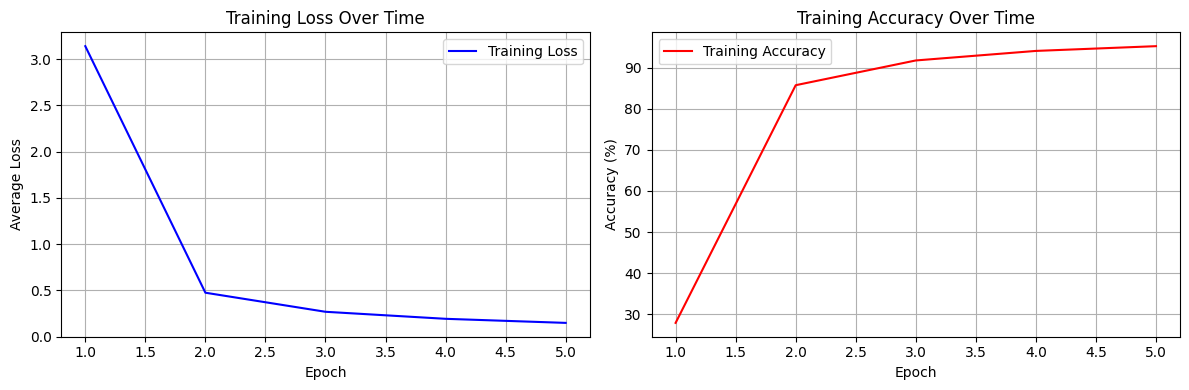

In [138]:
t_history = train(model,optimizer,5)
test(model)
plot_training_history(t_history)

#### Model - v2

Aplicamos la misma modificacion a la version 2. Esto reduce aun mas la cantidad de parametros requeridos.

In [139]:
class ModelV1(nn.Module):
    def __init__(self, img_width,img_height):
        super(ModelV1, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(10, 20, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(20, 40, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(40, 80, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(1280,50),
          nn.ReLU(),
          nn.Linear(50,100),
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = ModelV1(img_size,img_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [140]:
print_trainable_params(model)

num of parameters 174550


Epoch 1: Avg Loss: 4.606414, Accuracy: 1.10%
Epoch 2: Avg Loss: 4.556460, Accuracy: 3.10%
Epoch 3: Avg Loss: 1.451197, Accuracy: 60.16%
Epoch 4: Avg Loss: 0.380771, Accuracy: 88.44%
Epoch 5: Avg Loss: 0.240189, Accuracy: 92.44%

Test set: Avg. loss: 0.2100, Accuracy: 11224/12000 (94%)



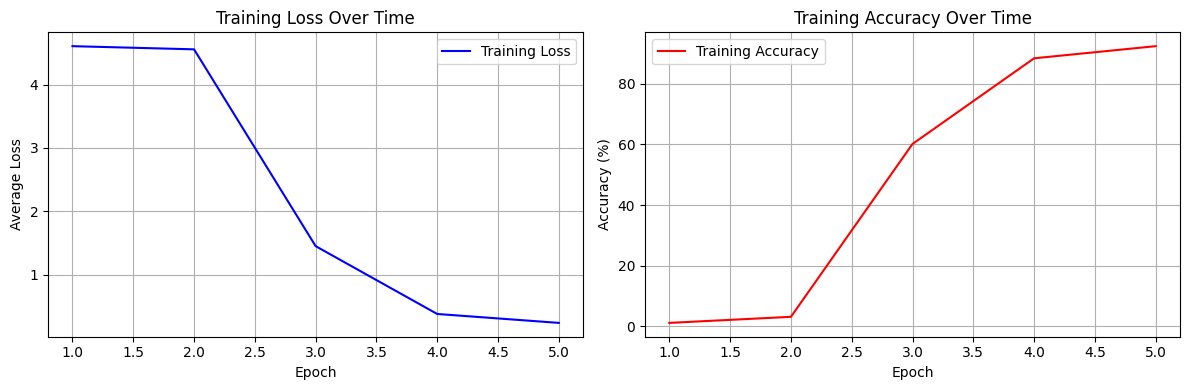

In [141]:
t_history = train(model,optimizer,5)
test(model)
plot_training_history(t_history)

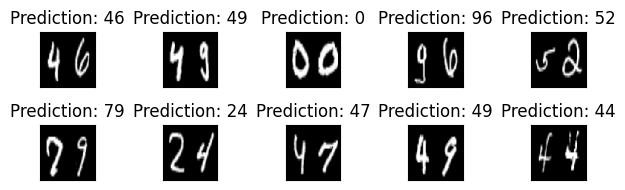

In [142]:
# Run network on data we got before and show predictions
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Evaluacion

### III-A. CNN

#### 1. Considere la siguiente matriz de entrada $X$:


$$
X = \begin{bmatrix}
2 & 5 & 4 & 1 \\
3 & 1 & 2 & 0 \\
4 & 5 & 7 & 1 \\
1 & 2 & 3 & 4
\end{bmatrix}
$$


##### a) Calcule la salida de una convolución con un kernel $K$ de dimensión $2 \times 2$, sin *padding* y con un *stride* de 2.



$$
K = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

RESPUESTA:

No hay mucho que explicar sobre el proceso usado para calcular la respuesta. Tambien es facil verificarla usando codigo y pytorch.

$$
\begin{align*}
res_{0,0} &= 2 * 1 + 5 * 0 + 3 * 0 + 1 * 1 = 3
\\
res_{0,1} &= 4 * 1 + 1 * 0 + 2 * 0 + 0 * 1 = 4
\\
res_{1,0} &= 4 * 1 + 5 * 0 + 1 * 0 + 2 * 1 = 6
\\
res_{1,1} &= 7 * 1 + 1 * 0 + 3 * 0 + 4 * 1 = 11
\\
\end{align*}
\\\\
Res = \begin{bmatrix}
3 & 4 \\
6 & 11
\end{bmatrix}
$$

##### b) Calcule la salida de una convolución con un kernel $K$ de dimensión $2 \times 2$, con *padding* de 2 y con un *stride* de 2.


$$
K = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

Con un padding de 2 la matriz a la que le realizariamos la convolucion seria:

$$
X = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 5 & 4 & 1 & 0 & 0 \\
0 & 0 & 3 & 1 & 2 & 0 & 0 & 0 \\
0 & 0 & 4 & 5 & 7 & 1 & 0 & 0 \\
0 & 0 & 1 & 2 & 3 & 4 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

$$
\begin{align*}
\begin{array}{ll}
res_{0,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{0,1} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{0,2} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{0,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{1,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{1,1} &= 2 * 1 + 5 * 0 + 3 * 0 + 1 * (-1) = 1 \\
res_{1,2} &= 4 * 1 + 1 * 0 + 2 * 0 + 0 * (-1) = 4 &
res_{1,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{2,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{2,1} &= 4 * 1 + 5 * 0 + 1 * 0 + 2 * (-1) = 2 \\
res_{2,2} &= 7 * 1 + 1 * 0 + 3 * 0 + 4 * (-1) = 3 &
res_{2,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{3,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{3,1} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{3,2} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{3,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0
\end{array}
\end{align*}
$$

$$
\text{Res} = \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 4 & 0 \\
0 & 2 & 3 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

#### 2. ¿Cómo podemos determinar la dimensión de salida luego de aplicar la función de convolución?


Esto dependera del kernel size, el padding, el stride y el dilation. El kernel size y el padding determinan cuantos "cuadrantes" tenemos disponibles para el calculo. Con cuadrante me refiero a la region que se operara con el kernel para obtener un elemento de la matriz resultante.

Aumentar el padding incrementa la cantidad de cuadrantes que podemos usar. Aumentar el stride, kernel size o dilation reduce la cantidad de cuadrantes.

Entonces la dimension final vendria dada (en filas y columnas) por:

[Referencia](https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer)

$$
[(matrix\_size−kernel\_size+2*padding)/stride]+1
$$

#### 3. ¿Qué beneficios tiene el uso de Redes Neuronales Convolucionales (CNNs) sobre las redes completamente conectadas?


1 - Se realizan menos operaciones. \\
2 - Mantienen el contexto del valor de cada pixel. Ya que la operacion de convolucion usa los vecinos de un pixel y no todos los valores de la imagen.

### III-B. CNN Segmentation

#### Depthwise Separable Convolution

NOTA: la informacion presentada e interpretaciones vienen de [este articulo](https://medium.com/data-science/efficient-image-segmentation-using-pytorch-part-3-3534cf04fb89).

Comenzando con la convolucion normal, suponiendo que se tiene un input de m canales, w de ancho y h de altura. Para obtener un resultado con 1 canal se requiere un kernel de $m * dk * dk$ **parametros**. Ahora si se quieren multiples canales (n) como resultado es necesario n kernels. Esto nos da un total de $dk * dk * n * m$ **parametros** entrenables.

Ahora, la convolucion separable es una funcion con las mismas dimensiones en el dominio y rango. A mi parecer cuando formularon esta funcion pensaron en realizar operaciones de convolucion de tal manera que sean necesario menos parametros y las dimensiones de entrada y salida sean las mismas, me hace pensar que deben existir otras formas de hacer esto. Me pregunto que otras restricciones existian antes de formular esta funcion.

Esta convolucion se realiza primero dividiendo el input en sus canales, a cada uno de estos se les aplicara 1 kernel (ya que sera 1 canal por input) de dk*dk. Esta primera operacion usara $dk * dk * m$ parametros.

Esto tendra como resultado una salida de m * h * w, que para transformar en n * h * w es necesario aplicarle otra operacion de convolucion. Esta operacion consiste de n kernels de longitud m, es decir que por cada indice del cuadrado w*h se le aplican n convoluciones a todos los elementos de esa casilla.

#### Metricas para segmentacion de imagenes

#### DICE

NOTA: La informacion presentada viene en parte de [este](https://lathashreeh.medium.com/dice-coefficient-what-is-it-ff090ec97bda) articulo. Varias de las interpretaciones son dadas luego de leerlo.

La intuicion de esta metrica es mas facil de obtener si pensamos en ella como valores entre 0 y 1 donde el 0 significa que no existe sobreposicion de los elementos en los conjuntos A y B y 1 que todos los elementos se sobreponen. Si observamos la formula:

$$
DICE = 2 * |A ∩ B| / (|A| + |B|)
$$

Vemos que si un conjunto tiene mas elementos que el otro, entonces es imposible que el coeficiente dice sea 1. El 2 multiplica ya que la interseccion de a y b nunca sera igual a la suma de sus elementos, si son exactamente iguales la interseccion sera exactamente la mitad.

Esta metrica penaliza los falsos positivos, por cada falso positivo el coeficiente es reducido. Ademas es mas efectivo que otras metricas con datasets no balanceados (comun en segmentacion de imagenes).

#### IOU

NOTA: La informacion presentada viene en parte de [este](https://medium.com/@ankuraga/iou-score-and-its-variants-for-deep-learning-bd09ecf14832) articulo. Varias de las interpretaciones son dadas luego de leerlo.

Esta metrica se usa tambien en tareas de detenccion de objetos. Mide la superposición entre la caja predicha y la verdadera. Se calcula de la siguiente manera:

$$
IOU = \text{Area of overlap} / \text{Area of union}
$$

Evidentemente por la formula podemos deducir que esta metrica va de 0 a 1. 1 Significa que toda el area de ambos elementos esta sobreposicionada. Aun asi dado que esta metrica usa cuadrados para saber si los elementos estan bien posicionados, considero es preferible DICE. Ya que una mascota y su prediccion pueden estar en la misma posicion pero sus bordes pueden haber sido estimados incorrectamente.

En el articulo podemos ver tambien otras metricas similares como **SIoU** (en caso de no haber interseccion usa valores negativos) y **GIoU** (una version mas generalizada de IOU).

#### Segmentación de imágenes con redes U-Net

Sobre el modelo a optimizar, esto se hizo en una copia del notebook original. Deberia estar adjunto con el nombre de **part3_partition.ipynb**, igual este se encuentra en este [repositorio](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/part3_partition.ipynb)